# Market Concentration

Diego Alvarez: diego.alvarez@colorado.edu <br>
GitHub: [here](https://github.com/diegodalvarez) <br>
LinkedIn: [here](https://www.linkedin.com/in/diegodalvarez/) <br>
Medium: [here](https://medium.com/@dial0663)  <br>
From: Man Numeric: Views From the Floor - Is the New Bull Market Here to Stay? [link](https://www.man.com/maninstitute/views-from-the-floor-2023-june-20)

## Packages

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

## Data Collection / Prep
Note: Once data is collected and saved, it does not update. To update the data, delete all of the parquet files <br>
All returns include dividends and splits

In [2]:
try:
    
    print("[INFO] Trying to locate the data")
    df = pd.read_parquet(
        path = "data.parquet",
        engine = "pyarrow")
    
    df_nasdaq = pd.read_parquet(
        path = "nasdaq.parquet",
        engine = "pyarrow")
    
    df_russell = pd.read_parquet(
        path = "russell.parquet",
        engine = "pyarrow")
    
    df_russell_equal_weight = pd.read_parquet(
        path = "russell_equal.parquet",
        engine = "pyarrow")
    
    print("[INFO] Data Found")
    
except:
    
    print("[ALERT] Collecting Data from Yahoo Finance")
    end_date = dt.date.today()
    start_date = dt.date(year = 2000, month = 1, day = 1)
    tickers = ["SPY", "RSP"]
    df = (yf.download(
        tickers = tickers,
        start = start_date,
        end = end_date)
        [["Adj Close"]])
    
    df.to_parquet(
        path = "data.parquet",
        engine = "pyarrow")
    
    df_nasdaq = (yf.download(
        tickers = ["QQQ"],
        start = start_date,
        end = end_date)
        [["Adj Close"]].
        rename(columns = {"Adj Close": "QQQ"}).
        pct_change(periods = 30 * 3).
        dropna().
        reset_index())
    
    df_nasdaq.to_parquet(
        path = "nasdaq.parquet",
        engine = "pyarrow")
    
    russell_tickers = ["IWM", "IWB", "IWV"]
    df_russell = (yf.download(
        tickers = russell_tickers,
        start = start_date,
        end = end_date)
        ["Adj Close"])
    
    df_russell.to_parquet(
        path = "russell.parquet",
        engine = "pyarrow")
    
    df_russell_equal = (yf.download(
        tickers = ["EQAL", "EQWS"],
        start = start_date,
        end = end_date)
        ["Adj Close"])
    
    df_russell_equal.to_parquet(
        path = "russell_equal.parquet",
        engine = "pyarrow")
    
    print("[INFO] Data Collected and saved to current directory")

[INFO] Trying to locate the data
[ALERT] Collecting Data from Yahoo Finance
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[INFO] Data Collected and saved to current directory


## Examining the spread of betwen cap-weighted and equal-weighted

In [3]:
df_spread = (df.dropna().reset_index().melt(
    id_vars = "Date").
    drop(columns = ["variable_0"]).
    rename(columns = {"variable_1": "ticker"}).
    pivot(index = "Date", columns = "ticker", values = "value").
    pct_change(periods = 3 * 30).
    dropna().
    assign(
        spread_diff = lambda x: x.SPY - x.RSP,
        z_score = lambda x: (x.spread_diff - x.spread_diff.rolling(window = 30 * 3).mean()) / x.spread_diff.rolling(window = 30 * 3).std()))

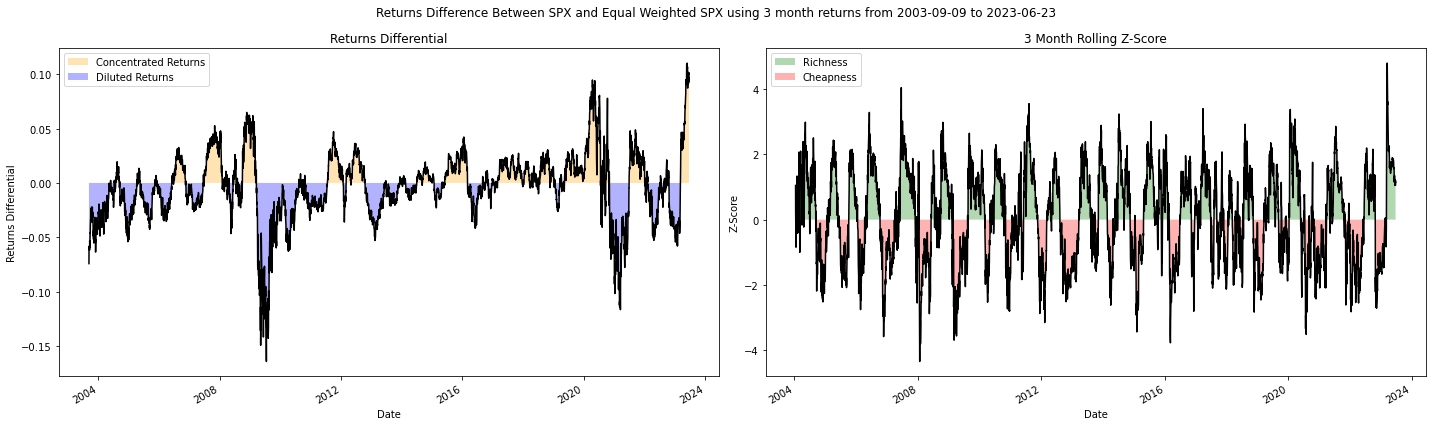

In [4]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))
(df_spread[
    ["spread_diff"]].
    plot(
        legend = False,
        ax = axes[0],
        ylabel = "Returns Differential",
        color = "black",
        title = "Returns Differential"))

axes[0].fill_between(
    x = df_spread.index,
    y1 = df_spread.spread_diff,
    y2 = 0,
    where = df_spread.spread_diff > 0,
    facecolor = "orange",
    alpha = 0.3)

axes[0].fill_between(
    x = df_spread.index,
    y1 = df_spread.spread_diff,
    y2 = 0,
    where = df_spread.spread_diff < 0,
    facecolor = "blue",
    alpha = 0.3)

legend_elements = [
    Patch(facecolor = "orange", alpha = 0.3, label = "Concentrated Returns"),
    Patch(facecolor = "blue", alpha = 0.3, label = "Diluted Returns")]

axes[0].legend(handles = legend_elements)

(df_spread[[
    "z_score"]].
    plot(
        legend = False,
        ax = axes[1],
        color = "black",
        ylabel = "Z-Score",
        title = "3 Month Rolling Z-Score"))

axes[1].fill_between(
    x = df_spread.index,
    y1 = df_spread.z_score,
    y2 = 0,
    where = df_spread.z_score > 0,
    facecolor = "green",
    alpha = 0.3)

axes[1].fill_between(
    x = df_spread.index,
    y1 = df_spread.z_score,
    y2 = 0,
    where = df_spread.z_score < 0,
    facecolor = "red",
    alpha = 0.3)

legend_elements = [
    Patch(facecolor = "green", alpha = 0.3, label = "Richness"),
    Patch(facecolor = "red", alpha = 0.3, label = "Cheapness")]

axes[1].legend(handles = legend_elements)

fig.suptitle("Returns Difference Between SPX and Equal Weighted SPX using 3 month returns from {} to {}".format(
    df_spread.index.min().date(),
    df_spread.index.max().date()))

plt.tight_layout()
plt.show()

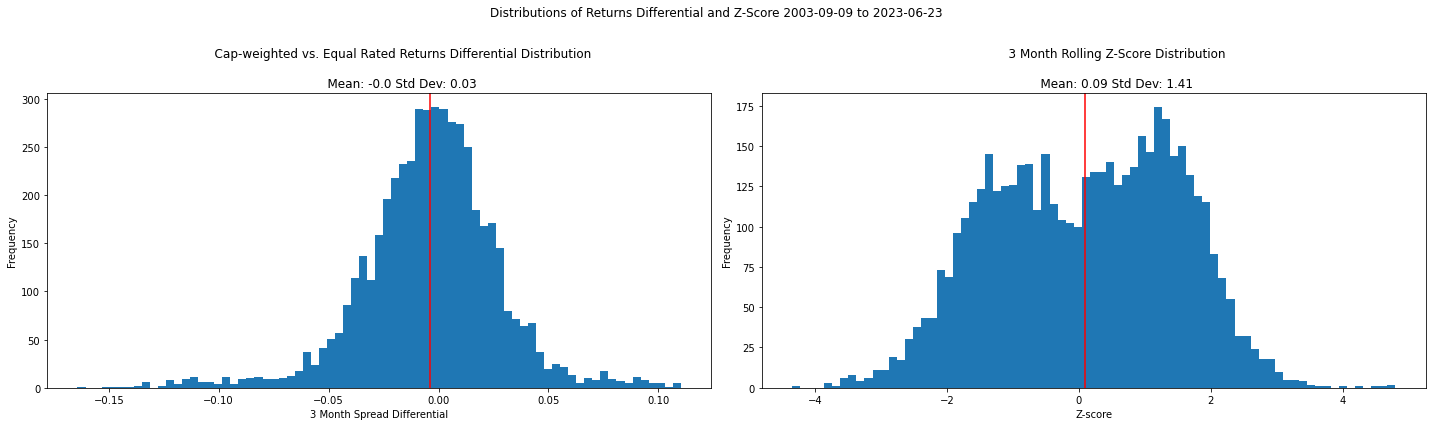

In [5]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

spread_diff_mean = df_spread.spread_diff.mean()
spread_diff_std = df_spread.spread_diff.std()

(df_spread[
    ["spread_diff"]].
    plot(
        kind = "hist", bins = 75, legend = False,
        ax = axes[0],
        title = '''
            Cap-weighted vs. Equal Rated Returns Differential Distribution\n 
            Mean: {} Std Dev: {}'''.format(
                round(spread_diff_mean, 2),
                round(spread_diff_std, 2))))

axes[0].axvline(
    x = spread_diff_mean,
    color = "r")

z_score_mean = df_spread.z_score.mean()
z_score_std = df_spread.z_score.std()

(df_spread[
    ["z_score"]].
    plot(
        kind = "hist", bins = 75, legend = False,
        ax = axes[1],
        title = '''
            3 Month Rolling Z-Score Distribution\n
            Mean: {} Std Dev: {}'''.format(
                round(z_score_mean, 2),
                round(z_score_std, 2))))

axes[1].axvline(
    x = df_spread.z_score.mean(),
    color = "r")

axes[0].set_xlabel("3 Month Spread Differential")
axes[1].set_xlabel("Z-score")

fig.suptitle("Distributions of Returns Differential and Z-Score {} to {}".format(
    df_spread.index.min().date(),
    df_spread.index.max().date()))

plt.tight_layout()
plt.show()

Plotting change in z-score as a distribution is not ideal, but I think it is important to show. <br>
The bi-modal shape of the Z-score distributions may comes from combining the positive and negative z-score values. 

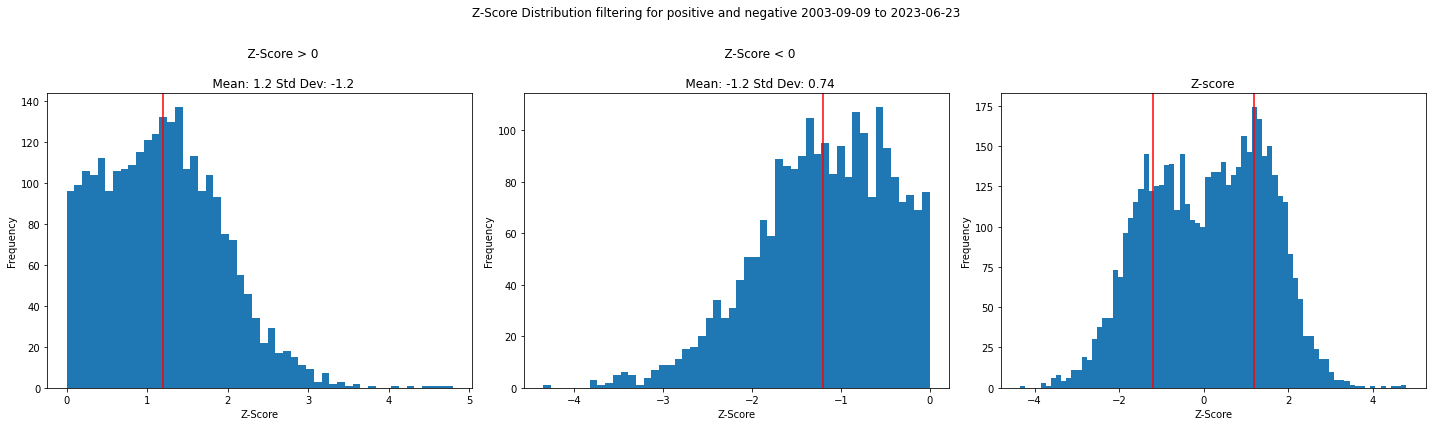

In [6]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,6))

positive_mean, positive_std = df_spread.query("z_score > 0").z_score.mean(), df_spread.query("z_score > 0").z_score.std()
negative_mean, negative_std = df_spread.query("z_score < 0").z_score.mean(), df_spread.query("z_score < 0").z_score.std()

(df_spread[
    ["z_score"]].
    query("z_score > 0").
    plot(
        ax = axes[0], kind = "hist", bins = 50,
        legend = False,
        title = '''
            Z-Score > 0\n 
            Mean: {} Std Dev: {}'''.format(
                round(positive_mean, 2),
                round(negative_mean, 2))))

axes[0].axvline(
    x = positive_mean,
    color = "r")

(df_spread[
    ["z_score"]].
    query("z_score < 0").
    plot(
        ax = axes[1], kind = "hist", bins = 50,
        legend = False,
        title = '''
            Z-Score < 0\n 
            Mean: {} Std Dev: {}'''.format(
                round(negative_mean, 2),
                round(negative_std, 2))))

axes[1].axvline(
    x = negative_mean,
    color = "r")

(df_spread[
    ["z_score"]].
    plot(
        ax = axes[2], kind = "hist", bins = 75,
        legend = False,
        title = "Z-score"))

axes[2].axvline(
    x = positive_mean,
    color = "r")

axes[2].axvline(
    x = negative_mean,
    color = "r")

for i in range(3): axes[i].set_xlabel("Z-Score")

fig.suptitle("Z-Score Distribution filtering for positive and negative {} to {}".format(
    df_spread.index.min().date(),
    df_spread.index.max().date()))

plt.tight_layout()
plt.show()

## Comparing returns differential to NASDAQ returns 

I'm including this, although I didn't like the results. I'd be remiss since it is important for the integrity of this model and the research to include all results, even poor ones.

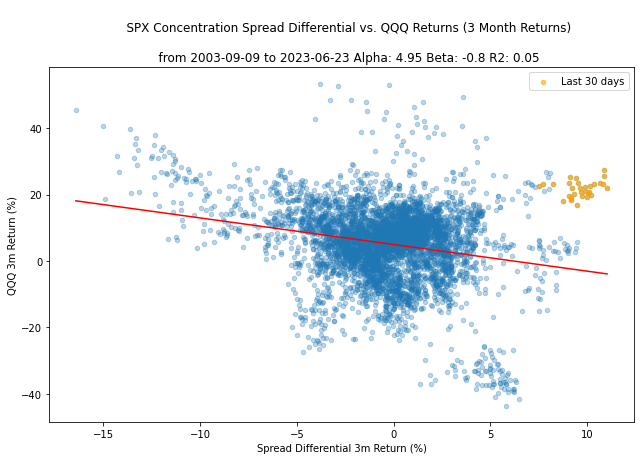

In [7]:
fig, axes = plt.subplots(figsize = (9, 6.5))

df_combined = (df_spread[
    ["spread_diff"]].
    merge(df_nasdaq, how = "left", on = ["Date"]))

df_combined = df_combined.set_index("Date") * 100

regression = (sm.OLS(
    endog = df_combined.QQQ,
    exog = sm.add_constant(df_combined.spread_diff)).
    fit())

alpha, beta = regression.params
x = np.linspace(
    start = df_combined.spread_diff.min(),
    stop = df_combined.spread_diff.max(),
    num = 1_000)

y = (x * beta) + alpha

(df_combined.plot(
    ax = axes, kind = "scatter",
    x = "spread_diff", y = "QQQ",
    alpha = 0.3,
    title = '''
    SPX Concentration Spread Differential vs. QQQ Returns (3 Month Returns)\n
    from {} to {} Alpha: {} Beta: {} R2: {}'''.format(
        df_combined.index.min().date(),
        df_combined.index.max().date(),
        round(alpha, 2),
        round(beta, 2),
        round(regression.rsquared, 2))))

(df_combined.tail(30).plot(
    ax = axes, kind = "scatter",
    x = "spread_diff", y = "QQQ",
    color = "orange",
    alpha = 0.6,
    label = "Last 30 days",
    ylabel = "QQQ 3m Return (%)",
    xlabel = "Spread Differential 3m Return (%)"))

axes.plot(x, y, color = "r")
plt.tight_layout()
plt.show()

## Comparing returns differential to Russell 1,000, 2,000, and 3,000
This is a better regression since we're expecting the "less-concentrated" part of the market to "catch-up" to the more "concentrated" parts

In [8]:
column_renamer = {
    "IWM": "Russell 2000",
    "IWB": "Russell 1000",
    "IWV": "Russell 3000"}

df_russell_rtn = (df_russell.dropna().pct_change(
    periods = 30 * 3).
    dropna())

df_combined = (df_spread[
    ["spread_diff", "z_score"]].
    merge(df_russell_rtn, how = "left", on = ["Date"]))

df_combined = df_combined * 100

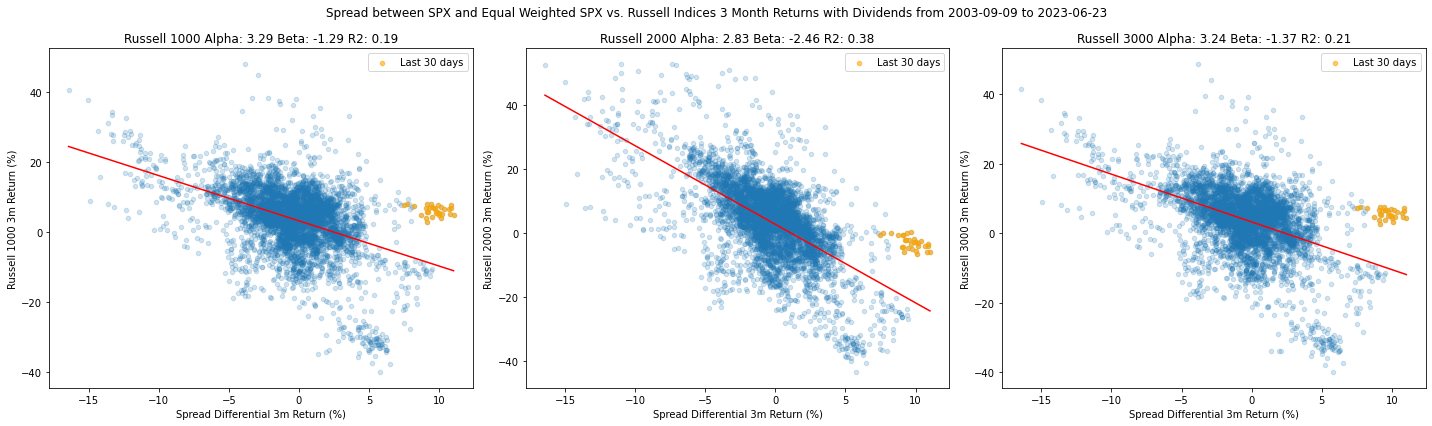

In [9]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,6))

(df_combined.plot(
    ax = axes[0], kind = "scatter",
    x = "spread_diff", y = "IWB",
    alpha = 0.2))

(df_combined.tail(30).plot(
    ax = axes[0], kind = "scatter",
    x = "spread_diff", y = "IWB",
    xlabel = "Spread Differential 3m Return (%)",
    ylabel = "Russell 1000 3m Return (%)",
    color = "orange",
    label = "Last 30 days",
    alpha = 0.6))

regression = (sm.OLS(
    endog = df_combined.IWB,
    exog = sm.add_constant(df_combined.spread_diff)).
    fit())

alpha, beta = regression.params
x = np.linspace(
    start = df_combined.spread_diff.min(),
    stop = df_combined.spread_diff.max(),
    num = 1_000)

y = (beta * x) + alpha
axes[0].plot(x, y, color = "r")
axes[0].set_title("Russell 1000 Alpha: {} Beta: {} R2: {}".format(
    round(alpha, 2),
    round(beta, 2),
    round(regression.rsquared, 2)))

(df_combined.plot(
    ax = axes[1], kind = "scatter",
    x = "spread_diff", y = "IWM",
    alpha = 0.2))

(df_combined.tail(30).plot(
    ax = axes[1], kind = "scatter",
    x = "spread_diff", y = "IWM",
    xlabel = "Spread Differential 3m Return (%)",
    ylabel = "Russell 2000 3m Return (%)",
    color = "orange",
    label = "Last 30 days",
    alpha = 0.6))

regression = (sm.OLS(
    endog = df_combined.IWM,
    exog = sm.add_constant(df_combined.spread_diff)).
    fit())

alpha, beta = regression.params
x = np.linspace(
    start = df_combined.spread_diff.min(),
    stop = df_combined.spread_diff.max(),
    num = 1_000)

y = (beta * x) + alpha
axes[1].plot(x, y, color = "r")
axes[1].set_title("Russell 2000 Alpha: {} Beta: {} R2: {}".format(
    round(alpha, 2),
    round(beta, 2),
    round(regression.rsquared, 2)))

(df_combined.plot(
    ax = axes[2], kind = "scatter",
    x = "spread_diff", y = "IWV",
    alpha = 0.2))

(df_combined.tail(30).plot(
    ax = axes[2], kind = "scatter",
    x = "spread_diff", y = "IWV",
    xlabel = "Spread Differential 3m Return (%)",
    ylabel = "Russell 3000 3m Return (%)",
    color = "orange",
    label = "Last 30 days",
    alpha = 0.6))

regression = (sm.OLS(
    endog = df_combined.IWV,
    exog = sm.add_constant(df_combined.spread_diff)).
    fit())

alpha, beta = regression.params
x = np.linspace(
    start = df_combined.spread_diff.min(),
    stop = df_combined.spread_diff.max(),
    num = 1_000)

y = (beta * x) + alpha
axes[2].plot(x, y, color = "r")
axes[2].set_title("Russell 3000 Alpha: {} Beta: {} R2: {}".format(
    round(alpha, 2),
    round(beta, 2),
    round(regression.rsquared, 2)))

fig.suptitle("Spread between SPX and Equal Weighted SPX vs. Russell Indices 3 Month Returns with Dividends from {} to {}".format(
    df_combined.index.min().date(),
    df_combined.index.max().date()))
plt.tight_layout()
plt.show()

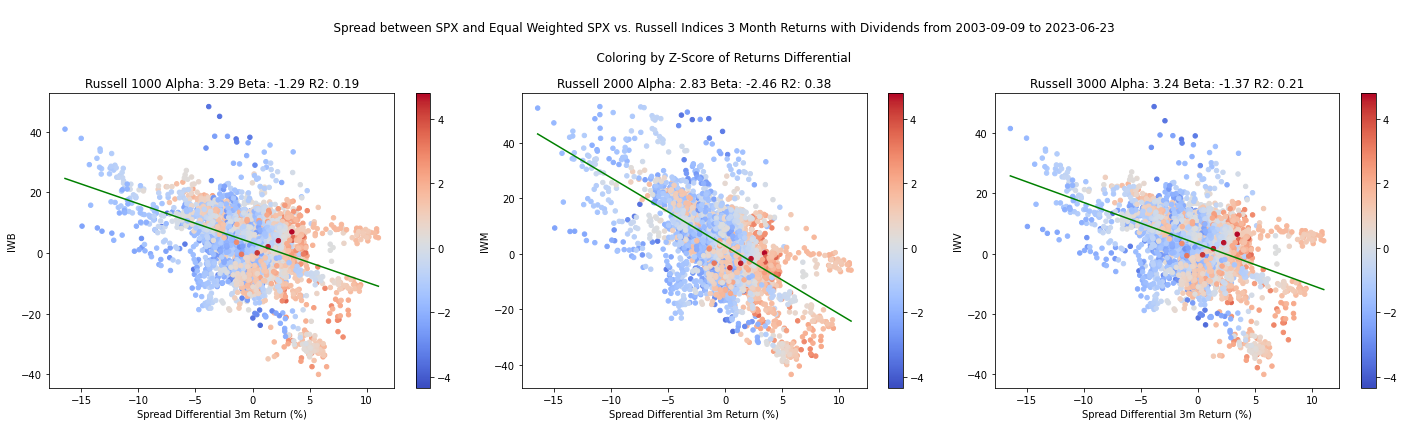

In [10]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,6))

(df_combined.plot(
    ax = axes[0], kind = "scatter",
    x = "spread_diff", y = "IWB",
    xlabel = "Spread Differential 3m Return (%)",
    c = df_combined.z_score / 100,
    cmap = "coolwarm"))

regression = (sm.OLS(
    endog = df_combined.IWB,
    exog = sm.add_constant(df_combined.spread_diff)).
    fit())

alpha, beta = regression.params
x = np.linspace(
    start = df_combined.spread_diff.min(),
    stop = df_combined.spread_diff.max(),
    num = 1_000)

y = (beta * x) + alpha
axes[0].plot(x, y, color = "g")
axes[0].set_title("Russell 1000 Alpha: {} Beta: {} R2: {}".format(
    round(alpha, 2),
    round(beta, 2),
    round(regression.rsquared, 2)))

(df_combined.plot(
    ax = axes[1], kind = "scatter",
    x = "spread_diff", y = "IWM",
    xlabel = "Spread Differential 3m Return (%)",
    c = df_combined.z_score / 100,
    cmap = "coolwarm"))

regression = (sm.OLS(
    endog = df_combined.IWM,
    exog = sm.add_constant(df_combined.spread_diff)).
    fit())

alpha, beta = regression.params
x = np.linspace(
    start = df_combined.spread_diff.min(),
    stop = df_combined.spread_diff.max(),
    num = 1_000)

y = (beta * x) + alpha
axes[1].plot(x, y, color = "g")
axes[1].set_title("Russell 2000 Alpha: {} Beta: {} R2: {}".format(
    round(alpha, 2),
    round(beta, 2),
    round(regression.rsquared, 2)))

(df_combined.plot(
    ax = axes[2], kind = "scatter",
    x = "spread_diff", y = "IWV",
    xlabel = "Spread Differential 3m Return (%)",
    c = df_combined.z_score / 100,
    cmap = "coolwarm"))

regression = (sm.OLS(
    endog = df_combined.IWV,
    exog = sm.add_constant(df_combined.spread_diff)).
    fit())

alpha, beta = regression.params
x = np.linspace(
    start = df_combined.spread_diff.min(),
    stop = df_combined.spread_diff.max(),
    num = 1_000)

y = (beta * x) + alpha
axes[2].plot(x, y, color = "g")
axes[2].set_title("Russell 3000 Alpha: {} Beta: {} R2: {}".format(
    round(alpha, 2),
    round(beta, 2),
    round(regression.rsquared, 2)))

fig.suptitle('''
    Spread between SPX and Equal Weighted SPX vs. Russell Indices 3 Month Returns with Dividends from {} to {}\n
    Coloring by Z-Score of Returns Differential'''.format(
    df_combined.index.min().date(),
    df_combined.index.max().date()))

plt.tight_layout()
plt.show()

In [11]:
df_combined_year = (df_combined.reset_index().assign(
    year = lambda x: x.Date.dt.year).
    set_index("Date"))

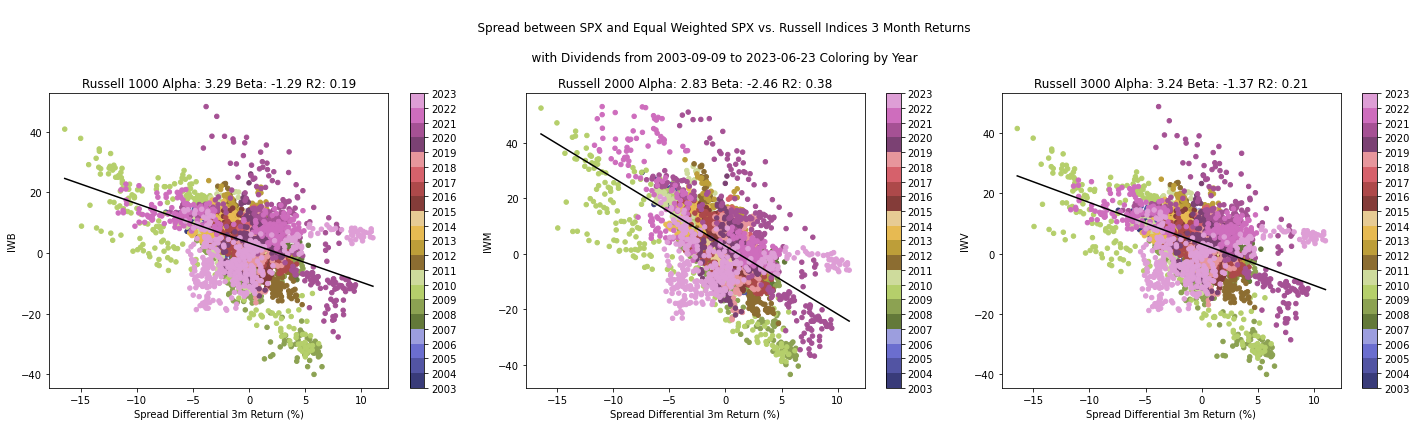

In [12]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,6))

scatter_plot1 = (df_combined.plot(
    ax = axes[0], kind = "scatter",
    x = "spread_diff", y = "IWB",
    xlabel = "Spread Differential 3m Return (%)",
    c = df_combined_year.year,
    cmap = "tab20b"))

cbar1 = scatter_plot1.collections[0].colorbar
cbar1.set_ticks(range(df_combined_year.year.min(), df_combined_year.year.max() + 1))
cbar1.set_ticklabels(range(df_combined_year.year.min(), df_combined_year.year.max() + 1))

regression = (sm.OLS(
    endog = df_combined.IWB,
    exog = sm.add_constant(df_combined.spread_diff)).
    fit())

alpha, beta = regression.params
x = np.linspace(
    start = df_combined.spread_diff.min(),
    stop = df_combined.spread_diff.max(),
    num = 1_000)

y = (beta * x) + alpha
axes[0].plot(x, y, color = "black")
axes[0].set_title("Russell 1000 Alpha: {} Beta: {} R2: {}".format(
    round(alpha, 2),
    round(beta, 2),
    round(regression.rsquared, 2)))

scatter_plot2 = (df_combined.plot(
    ax = axes[1], kind = "scatter",
    x = "spread_diff", y = "IWM",
    xlabel = "Spread Differential 3m Return (%)",
    c = df_combined_year.year,
    cmap = "tab20b"))

cbar2 = scatter_plot2.collections[0].colorbar
cbar2.set_ticks(range(df_combined_year.year.min(), df_combined_year.year.max() + 1))
cbar2.set_ticklabels(range(df_combined_year.year.min(), df_combined_year.year.max() + 1))

regression = (sm.OLS(
    endog = df_combined.IWM,
    exog = sm.add_constant(df_combined.spread_diff)).
    fit())

alpha, beta = regression.params
x = np.linspace(
    start = df_combined.spread_diff.min(),
    stop = df_combined.spread_diff.max(),
    num = 1_000)

y = (beta * x) + alpha
axes[1].plot(x, y, color = "black")
axes[1].set_title("Russell 2000 Alpha: {} Beta: {} R2: {}".format(
    round(alpha, 2),
    round(beta, 2),
    round(regression.rsquared, 2)))

scatter_plot3 = (df_combined.plot(
    ax = axes[2], kind = "scatter",
    x = "spread_diff", y = "IWV",
    xlabel = "Spread Differential 3m Return (%)",
    c = df_combined_year.year,
    cmap = "tab20b"))

cbar3 = scatter_plot3.collections[0].colorbar
cbar3.set_ticks(range(df_combined_year.year.min(), df_combined_year.year.max() + 1))
cbar3.set_ticklabels(range(df_combined_year.year.min(), df_combined_year.year.max() + 1))

regression = (sm.OLS(
    endog = df_combined.IWV,
    exog = sm.add_constant(df_combined.spread_diff)).
    fit())

alpha, beta = regression.params
x = np.linspace(
    start = df_combined.spread_diff.min(),
    stop = df_combined.spread_diff.max(),
    num = 1_000)

y = (beta * x) + alpha
axes[2].plot(x, y, color = "black")
axes[2].set_title("Russell 3000 Alpha: {} Beta: {} R2: {}".format(
    round(alpha, 2),
    round(beta, 2),
    round(regression.rsquared, 2)))

fig.suptitle('''
    Spread between SPX and Equal Weighted SPX vs. Russell Indices 3 Month Returns\n
    with Dividends from {} to {} Coloring by Year'''.format(
    df_combined.index.min().date(),
    df_combined.index.max().date()))

plt.tight_layout()
plt.show()

## Same examination with Equal Weight Russell 1000 and 2000

In [13]:
df_russell_equal_prep1 = (df_russell_equal.pct_change(
    periods = 3 * 30).
    rename(columns = {
        "EQAL": "equal_1000",
        "EQWS": "equal_2000"}).
    dropna())

It appears that there is a good amount of 0% returns 

In [14]:
df_zero_count = (df_russell_equal_prep1[
    ["equal_2000"]].
    round(2).
    assign(size_ = 0).
    groupby("equal_2000").
    agg("count").
    sort_values("size_", ascending = False).
    assign(
        count_ = lambda x: np.sum(x.size_),
        proportion = lambda x: x.size_ / x.count_).
    reset_index().
    query("equal_2000 == 0").
    replace({0.0: "0%"}))

zero_count = (df_zero_count.append(pd.DataFrame({
    "equal_2000": "not 0%",
    "size_": [df_zero_count.count_[0] - df_zero_count.size_[0]],
    "count_": [df_zero_count.count_[0]],
    "proportion": [1 - df_zero_count.proportion[0]]})).
    rename(columns = {
        "equal_2000": "returns",
        "size_": "size",
        "count_": "count"}).
    set_index("returns"))

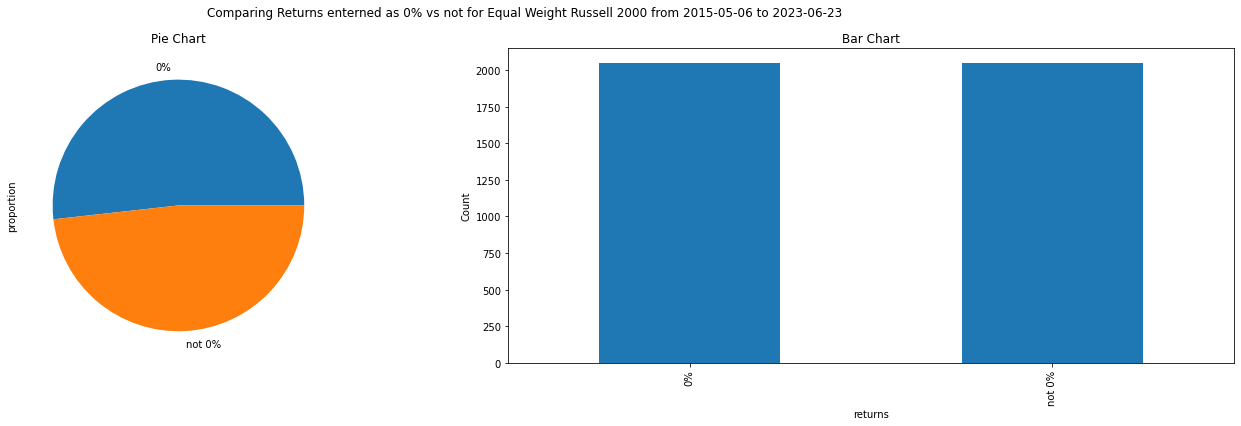

In [15]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

(zero_count.plot.pie(
    y = "proportion", 
    ax = axes[0], 
    legend = False,
    title = "Pie Chart"))

(zero_count[
    ["count"]].
    plot(
        kind = "bar", ax = axes[1],
        legend = False,
        title = "Bar Chart", 
        ylabel = "Count"))

fig.suptitle("Comparing Returns enterned as 0% vs not for Equal Weight Russell 2000 from {} to {}".format(
    df_russell_equal_prep1.index.min().date(),
    df_russell_equal_prep1.index.max().date()))

plt.tight_layout()
plt.show()

And they all appear to be right next to eachother

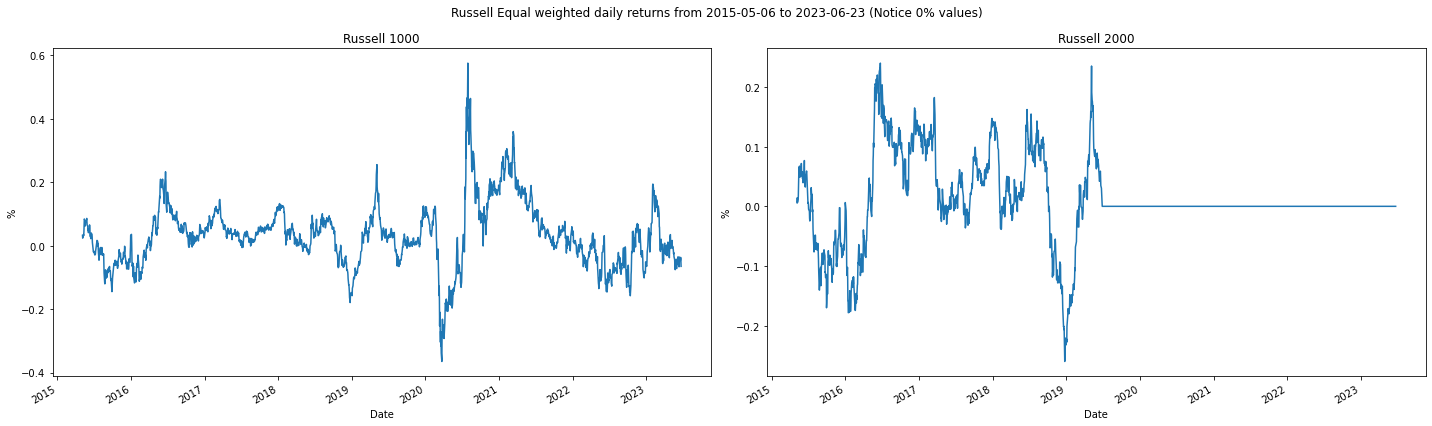

In [16]:
fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

(df_russell_equal_prep1[
    ["equal_1000"]].
    plot(
        ax = axes[0], legend = False,
        title = "Russell 1000",
        ylabel = "%"))

(df_russell_equal_prep1[
    ["equal_2000"]].
    plot(
        ax = axes[1], legend = False,
        title = "Russell 2000",
        ylabel = "%"))

fig.suptitle("Russell Equal weighted daily returns from {} to {} (Notice 0% values)".format(
    df_russell_equal_prep1.index.min().date(),
    df_russell_equal_prep1.index.max().date()))

plt.tight_layout()
plt.show()

Take out 0 returns and merge data to returns differentials

In [17]:
df_merged = ((df_russell_equal_prep1.query(
    "equal_2000 != 0").
    reset_index().
    merge(df_spread.reset_index(), how = "inner", on = ["Date"]).
    drop(columns = ["RSP", "SPY"]).
    set_index("Date") * 
    100))

Plot same regressions

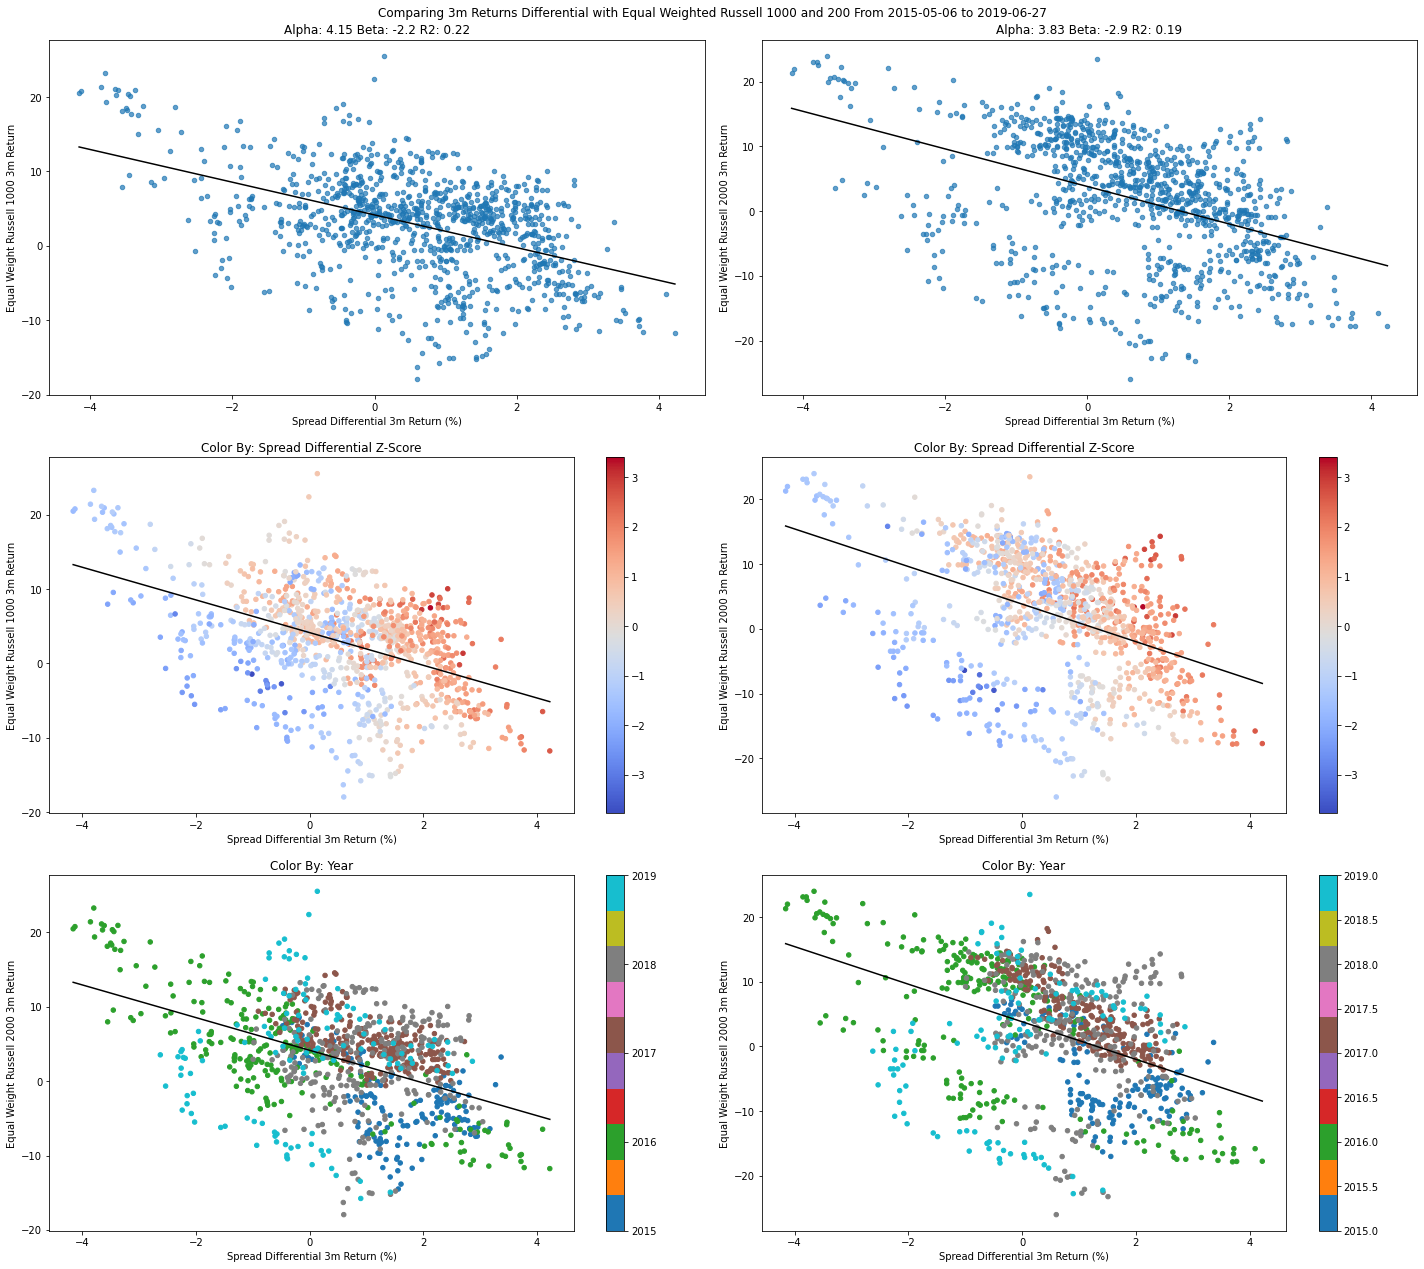

In [18]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 6 * 3))

regression1 = (sm.OLS(
    endog = df_merged.equal_1000,
    exog = sm.add_constant(df_merged.spread_diff)).
    fit())

alpha1, beta1 =  regression1.params

x1 = np.linspace(
    start = df_merged.spread_diff.min(),
    stop = df_merged.spread_diff.max(),
    num = 1_000)

y1 = (x1 * beta1) + alpha1

regression2 = (sm.OLS(
    endog = df_merged.equal_2000,
    exog = sm.add_constant(df_merged.spread_diff)).
    fit())

alpha2, beta2 =  regression2.params

x2 = np.linspace(
    start = df_merged.spread_diff.min(),
    stop = df_merged.spread_diff.max(),
    num = 1_000)

y2 = (x2 * beta2) + alpha2

for i in range(3):

    axes[i,0].plot(x1, y1, color = "black")
    axes[i,1].plot(x2, y2, color = "black")

(df_merged.plot(
    kind = "scatter", x = "spread_diff", y = "equal_1000",
    ax = axes[0,0],
    alpha = 0.7,
    xlabel = "Spread Differential 3m Return (%)",
    ylabel = "Equal Weight Russell 1000 3m Return",
    title = "Alpha: {} Beta: {} R2: {}".format(
        round(alpha1, 2),
        round(beta1, 2),
        round(regression1.rsquared, 2))))

(df_merged.plot(
    kind = "scatter", x = "spread_diff", y = "equal_2000",
    ax = axes[0,1],
    alpha = 0.7,
    xlabel = "Spread Differential 3m Return (%)",
    ylabel = "Equal Weight Russell 2000 3m Return",
    title = "Alpha: {} Beta: {} R2: {}".format(
        round(alpha2, 2),
        round(beta2, 2),
        round(regression2.rsquared, 2))))

(df_merged.plot(
    kind = "scatter", x = "spread_diff", y = "equal_1000",
    ax = axes[1,0],
    c = df_merged.z_score / 100,
    cmap = "coolwarm",
    title = "Color By: Spread Differential Z-Score",
    xlabel = "Spread Differential 3m Return (%)",
    ylabel = "Equal Weight Russell 1000 3m Return"))

(df_merged.plot(
    kind = "scatter", x = "spread_diff", y = "equal_2000",
    ax = axes[1,1],
    c = df_merged.z_score / 100,
    cmap = "coolwarm",
    title = "Color By: Spread Differential Z-Score",
    xlabel = "Spread Differential 3m Return (%)",
    ylabel = "Equal Weight Russell 2000 3m Return"))

df_merged_year = (df_merged.reset_index().assign(
    year_date = lambda x: x.Date.dt.year))

scatter_plot1 = (df_merged_year.plot(
    ax = axes[2,0],
    kind = "scatter", x = "spread_diff", y = "equal_1000",
    c = df_merged_year.year_date,
    cmap = "tab10",
    title = "Color By: Year",
    xlabel = "Spread Differential 3m Return (%)",
    ylabel = "Equal Weight Russell 2000 3m Return"))

cbar1 = scatter_plot1.collections[0].colorbar
cbar1.set_ticks(range(df_merged_year.year_date.min(), df_merged_year.year_date.max() + 1))
cbar1.set_ticklabels(range(df_merged_year.year_date.min(), df_merged_year.year_date.max() + 1))

(df_merged_year.plot(
    ax = axes[2,1],
    kind = "scatter", x = "spread_diff", y = "equal_2000",
    c = df_merged_year.year_date,
    cmap = "tab10",
    title = "Color By: Year",
    xlabel = "Spread Differential 3m Return (%)",
    ylabel = "Equal Weight Russell 2000 3m Return"))

fig.suptitle("Comparing 3m Returns Differential with Equal Weighted Russell 1000 and 200 From {} to {}".format(
    df_merged.index.min().date(),
    df_merged.index.max().date()))

plt.tight_layout(pad = 1.5)

## Conclusion

It is somewhat clear that there is negative linear relationship between spread of the returns differential and small caps. This implies that the less concentrated companies "catch-up". The regressions are not as solid as I'd like them to be given that the maximum $R^2$ is 0.38, although markets won't fit perfectly. <br> <br>
I'd like to further examin this via rolling regression. <br> In terms of factor space there are two directions to look into the large cap vs. small cap factors. A possible idea would be to use rolling returns (and later rolling OLS variables) for each factor and then comparing a lagged small caps to large cap, since we expect the small caps to "catch-up" to the large caps. One of the problems with this model is that it is very easy to overfit, given that we would need to find a suitable period to lag. Although the results from this model may be promising and we can enhance the model with latent-factor models, which opens up the world of many other more complex models, we can easily overfit our original data, and greatly overfit our latent-model factor.